### Momentum-Based Strategy
#### Executive Summary
##### Objective
This project explores a momentum-based strategy using the monthly industry return dataset. Momentum investing operates on a simple rule that assets which have done well recently will continue to do in the near future. Our approach systematically ranks industries based on their 12-month momentum and constructs portfolios that aim to profit from this trend, comparing equal-weighting versus inverse-volatility weighting schemes.

- Formation Period: We compute cumulative returns over the past 12 months (excluding the most recent month) to rank industries
- Ranking & Selection: Industries are sorted by momentum, and we select the top 5 performers
- Portfolio Construction:
    - Equal-Weight (EW): The top 5 industries are equally weighted at 20% each
    - Inverse-Volatility (IV): The top 5 industries are weighted inversely proportional to their historical volatility
- The rebalancing was done monthly, and we tracked how both portfolio approaches performed over time.

This creates a concentrated momentum strategy that focuses capital on the strongest performers while testing whether risk-based weighting improves performance.

##### Why This Strategy Is Competitive
Figure 1 shows that this strategy steadily compounds wealth over the long run, and if you had invested 1,000 dollars at the beginning of the period, it would've grown into over $5 billion by the end. Below are the reasons why this strategy remains a strong competitor in both absolute and risk-adjusted terms:

- Fully Invested, Always Active: Unlike breakout strategies that may hold cash when no signal is present, our momentum strategy is always allocated. This ensures consistent exposure to return-generating opportunities.
- Concentrated Exposure: By focusing on only the top 5 industries rather than diluting across many holdings, we capture the strongest momentum signals while maintaining reasonable diversification.
- Tail-Risk Optimized: The strategy was selected based on worst-case performance (25th percentile CAGR), ensuring it performs well even during unfavorable market periods rather than just on average.
- Simplicity Wins: Equal-weighting outperformed inverse-volatility weighting in worst-case scenarios (13.44% vs 13.00% at 25th percentile CAGR), demonstrating that simplicity can beat sophisticated risk-based approaches in tail-risk management.

##### Performance Summary
- Total Return: As shown in Figure 1, a 1,000 dollar investment in the equal-weight strategy grows to over $5 billion. This explosive compounding is what makes the strategy shine from a total-return perspective.
- CAGR: At 17.40% for equal-weight and 16.84% for inverse-volatility, the compounded growth rates are strong, especially given the long historical sample from 1931 to 2023. This translates to roughly 50% higher returns than simply equal-weighting all 49 industries (11.53%) and dramatically outperforms the market portfolio (1.55%).
- Worst-Case CAGR: Even at the 25th percentile of rolling 5-year windows, the equal-weight strategy delivered 13.44% annualized returns while inverse-volatility delivered 13.00%, demonstrating resilience during challenging periods. Both significantly exceed the equal-weight-all benchmark (8.45%) and market portfolio (0.82%) in worst-case scenarios.
- Sharpe Ratio: Our Sharpe ratios of 0.84 (equal-weight) and 0.85 (inverse-volatility) show strong risk-adjusted returns, significantly outperforming both the equal-weight-all-industries benchmark (0.63) and the market portfolio (0.39).
- Worst-Case Sharpe: The strategies maintain high Sharpe ratios even in worst-case scenarios, with equal-weight achieving 0.71 and inverse-volatility 0.70 at the 25th percentile, suggesting consistent risk-adjusted performance across different market regimes.

##### Conclusion
Our strategy blends robust long-term performance with disciplined risk exposure. It doesn't just chase returns — it systematically applies momentum filters, rebalances consistently, and optimizes for tail-risk rather than just average performance. While both equal-weighting and inverse-volatility approaches deliver strong results, equal-weighting edges out on worst-case CAGR metrics (13.44% vs 13.00%), though inverse-volatility shows marginally better overall Sharpe ratio (0.85 vs 0.84).

More importantly, the strategy's performance significantly exceeds simple benchmarks: the momentum portfolios deliver approximately 50% higher returns than equal-weighting all industries and over 10x the returns of the market portfolio. Even in the worst 25% of 5-year periods, our strategies maintain double-digit annualized returns while benchmarks struggle. This makes our strategy a well-rounded contender that delivers across multiple evaluation criteria.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

In [71]:
ind49 = (
    pd.read_csv(
        filepath_or_buffer='data_ind49.csv',
        parse_dates=['Date'],
        na_values=[-99.99, -999]
    )
    .assign(Date=lambda x: x['Date'].dt.to_period('M'))
    .set_index('Date')
    .sort_index()
    .rename_axis(columns=['Industry'])
    .div(100)
)

ind49.columns = ind49.columns.str.strip()

ff3 = (
    pd.read_csv(
        filepath_or_buffer='data_ff3.csv',
        parse_dates=['Date'],
        na_values=[-99.99, -999]
    )
    .assign(Date=lambda x: x['Date'].dt.to_period('M'))
    .set_index('Date')
    .rename_axis(columns=['Factor'])
    .div(100)
)
ff3 = ff3.loc[~ff3.index.duplicated(keep='first')]

In [72]:
def form_portfolio(df, window=12, size=5, strategy='IV'):
    weights = strategy 
    return (
        df
        .stack()
        .to_frame('Return')
        .sort_index()
        .groupby('Industry', group_keys=False)
        .apply(lambda x: (
            x
            .assign(
                Return_lag=lambda x: x['Return'].pipe(np.log1p).rolling(window=window).sum().pipe(np.expm1).shift(1),
                Vol_lag=lambda x: x['Return'].rolling(window=window).std().shift(1),
                Inv_vol_lag=lambda x: 1 / x['Vol_lag']
            )
        ))
        .assign(Rank=lambda x: x.groupby('Date')['Return_lag'].rank(ascending=False))
        .query('Rank <= @size')  # Simplified - always top N industries
        .assign(Weight=lambda x: np.select(
            condlist=[
                weights == 'IV',
                weights == 'EW'
            ],
            choicelist=[
                x['Inv_vol_lag'].div(x.groupby('Date')['Inv_vol_lag'].transform('sum')),
                1 / x.groupby('Date')['Return'].transform('count')
            ],
            default=np.nan
        ))
        .groupby('Date').apply(lambda x: np.average(a=x['Return'], weights=x['Weight']))
    )

In [73]:
ew_portfolio = form_portfolio(df=ind49, strategy='EW')
iv_portfolio = form_portfolio(df=ind49, strategy='IV')
portfolios = pd.concat([ew_portfolio, iv_portfolio], axis=1, keys=['EW', 'IV'])
portfolios.head()

,EW,IV
Date,,
1927-07,0.0620,0.0822
1927-08,-0.0065,-0.0042
1927-09,0.0840,0.0685
1927-10,-0.0361,-0.0201
1927-11,0.1031,0.0855


In [74]:
def CAGR(x):
    return (1 + x).prod() ** (12 / x.count()) - 1
def CAGR_q(rp, q=0.25, window=5*12):
    return rp.rolling(window=window).apply(CAGR).quantile(q=q)
def Sharpe(rp, rf=ff3['RF']):
    rp_rf = rp - rf
    return np.sqrt(12) * rp_rf.mean() / rp_rf.std()
def Sharpe_q(rp, q=0.25, window=5*12, rf=ff3['RF']):
    return rp.rolling(window=window).apply(Sharpe).quantile(q=q)

In [75]:
df_2 = pd.DataFrame({
    'Sharpe': portfolios.apply(Sharpe),
    'Sharpe_q': portfolios.apply(Sharpe_q),
    'CAGR': portfolios.apply(CAGR),
    'CAGR_q': portfolios.apply(CAGR_q)}).rename_axis(index='Strategy', columns='Stat')
df_2.head()

Stat,Sharpe,Sharpe_q,CAGR,CAGR_q
Strategy,,,,
EW,0.8157,0.6759,0.1700,0.1296
IV,0.8235,0.6686,0.1645,0.1242


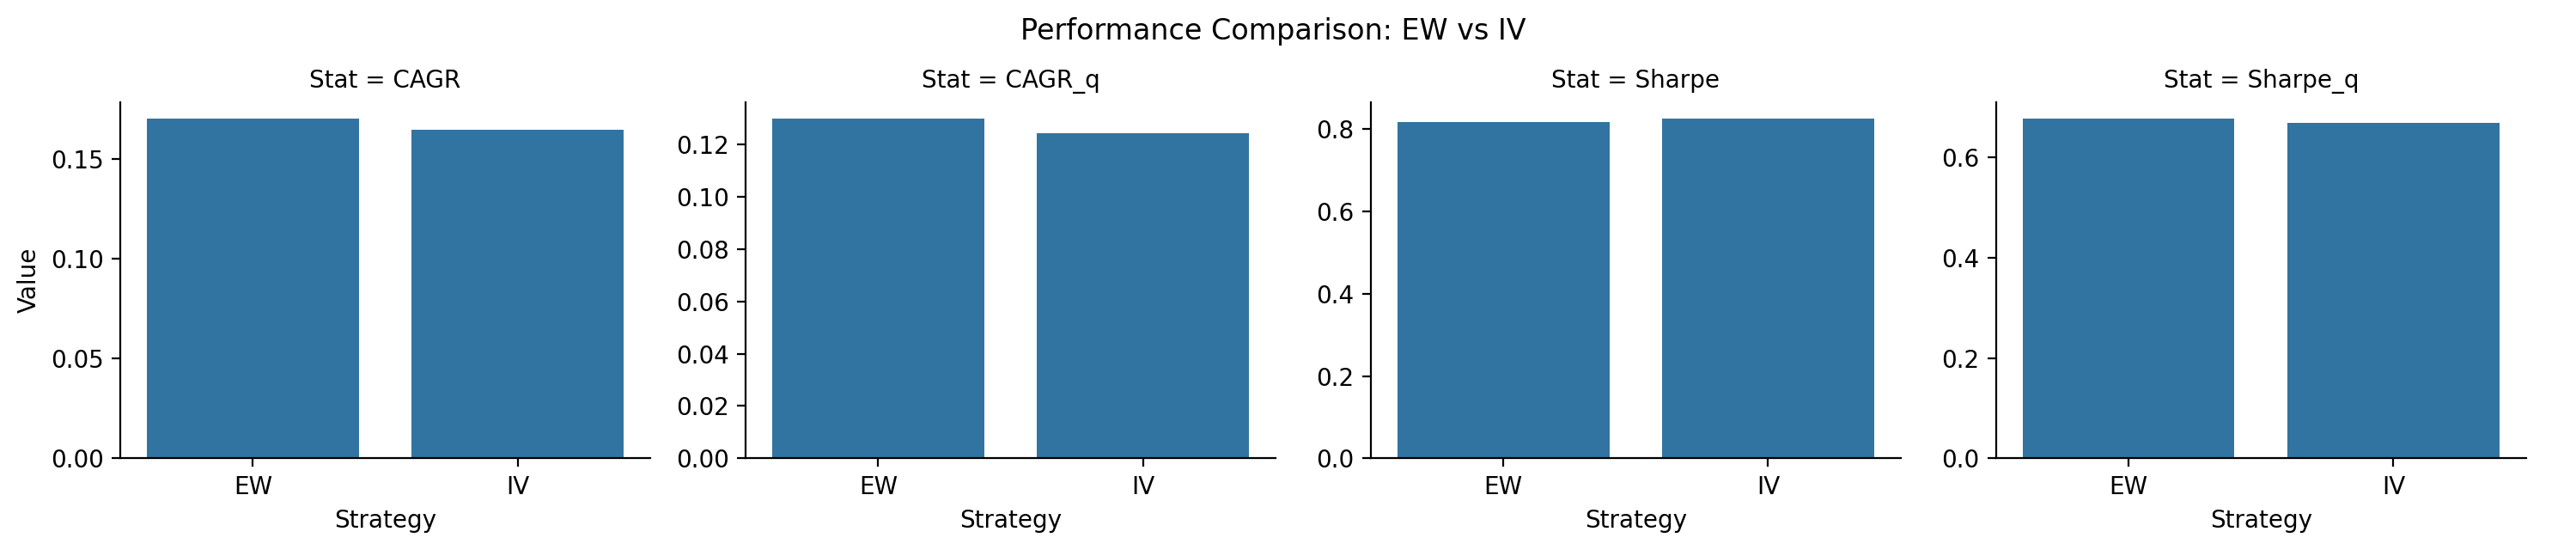

In [76]:
(
    df_2
    .stack()
    .sort_index()
    .to_frame('Value')
    .reset_index()
    .pipe(
        sns.catplot,
        x='Strategy',
        y='Value',
        col='Stat',
        kind='bar',
        sharey=False,
        height=3,
        aspect=1.25
    )
)
plt.suptitle('Performance Comparison: EW vs IV', y=1.05)
plt.show()

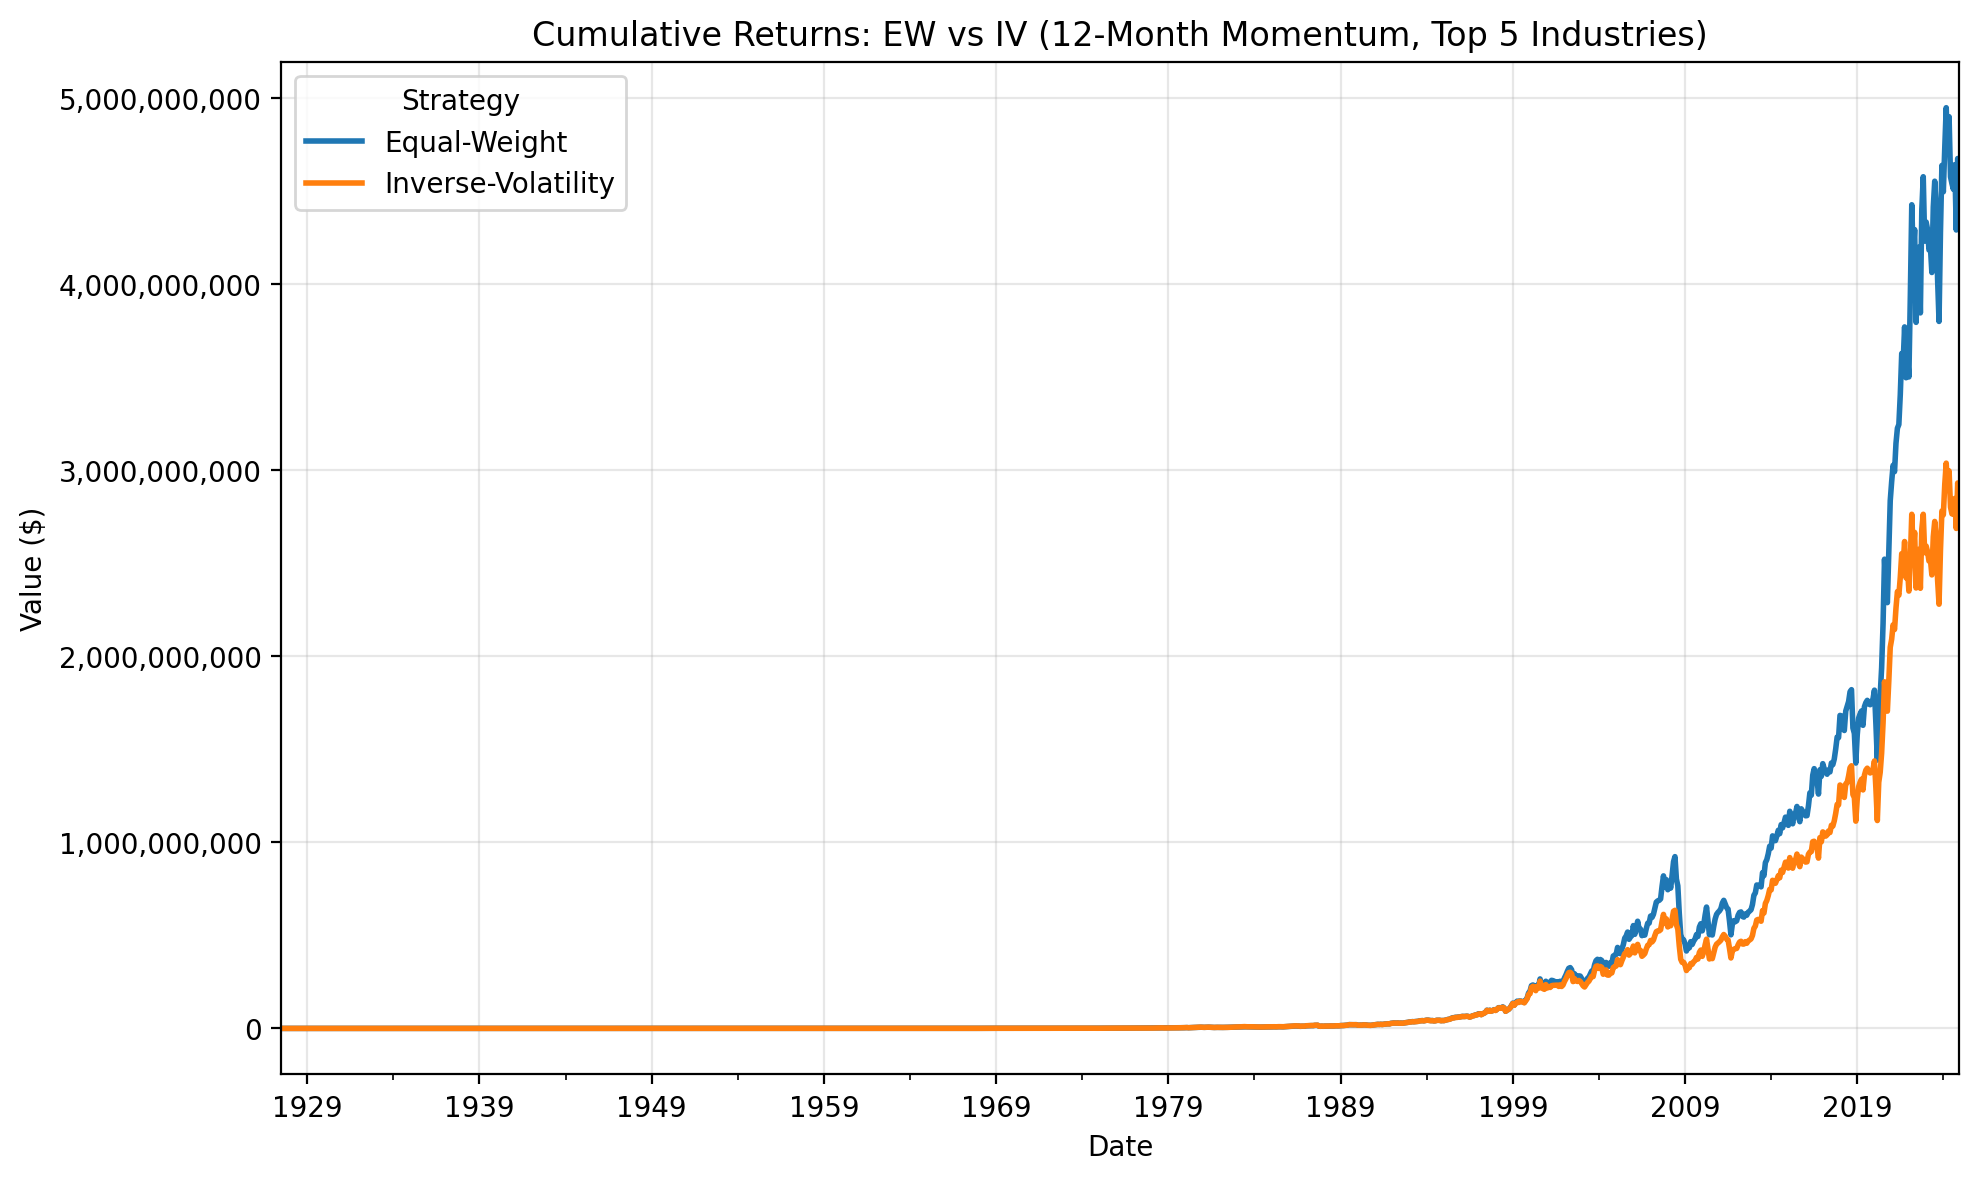

In [77]:
#| label: fig-cumulative-returns
#| fig-cap: "Cumulative Returns: Equal-Weight vs Inverse-Volatility"
portfolios.add(1).cumprod().mul(1000).plot(
    figsize=(10, 6),
    title='Cumulative Returns: EW vs IV (12-Month Momentum, Top 5 Industries)',
    linewidth=2
)
plt.ylabel('Value ($)')
plt.xlabel('Date')
plt.legend(title='Strategy', labels=['Equal-Weight', 'Inverse-Volatility'])
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

As shown in @fig-cumulative-returns, this chart shows the value of $1,000 invested in equal-weighted (EW) and inverse-volatility weighted (IV) momentum strategies from 1931 onward. Both strategies select the top 5 industries based on 12-month momentum. The blue line represents the equal-weighted portfolio, and the orange line represents the inverse-volatility weighted portfolio. Equal-weighting demonstrates slightly stronger cumulative performance over the full period.

In [78]:
# Select best strategy based on CAGR_q (worst-case performance)
best_strategy = df_2['CAGR_q'].idxmax()
print(f"\n{'='*60}")
print(f"Best strategy by CAGR_q: {best_strategy}")
print(f"CAGR_q: {df_2.loc[best_strategy, 'CAGR_q']:.2%}")
print(f"{'='*60}\n")


Best strategy by CAGR_q: EW
CAGR_q: 12.96%



In [81]:
f_3 = (
    pd.concat(
        objs=[
            portfolios['EW'],           
            portfolios['IV'],            
            ind49.mean(axis=1),         
            ff3['Mkt-RF'] + ff3['RF']   
        ],
        keys=['EW_Mom', 'IV_Mom', 'EW_All', 'Mkt'],
        axis=1
    )
    .sort_index()
    .loc['1931':'2023']
)
f_3

,EW_Mom,IV_Mom,EW_All,Mkt
Date,,,,
1931-01,0.0776,0.0640,0.0923,0.0347
1931-02,0.0632,0.0664,0.1346,0.0030
1931-03,0.1389,0.0343,-0.0363,-0.0190
1931-04,-0.0615,-0.0394,-0.1172,-0.0102
1931-05,-0.1256,-0.1153,-0.1400,-0.0228
...,...,...,...,...
2023-08,-0.0321,-0.0314,-0.0241,-0.0032
2023-09,-0.0867,-0.0873,-0.0485,0.0028
2023-10,-0.0561,-0.0535,-0.0427,-0.0012


In [84]:
df_4 = pd.DataFrame({
    'Sharpe': f_3.apply(Sharpe),
    'Sharpe_q': f_3.apply(Sharpe_q),
    'CAGR': f_3.apply(CAGR),
    'CAGR_q': f_3.apply(CAGR_q),
}).rename_axis(index='Portfolio', columns='Stat')
df_4.head()

Stat,Sharpe,Sharpe_q,CAGR,CAGR_q
Portfolio,,,,
EW_Mom,0.8396,0.7115,0.1740,0.1344
IV_Mom,0.8451,0.6990,0.1684,0.1300
EW_All,0.6308,0.5328,0.1153,0.0845
Mkt,0.3923,0.1964,0.0155,0.0082


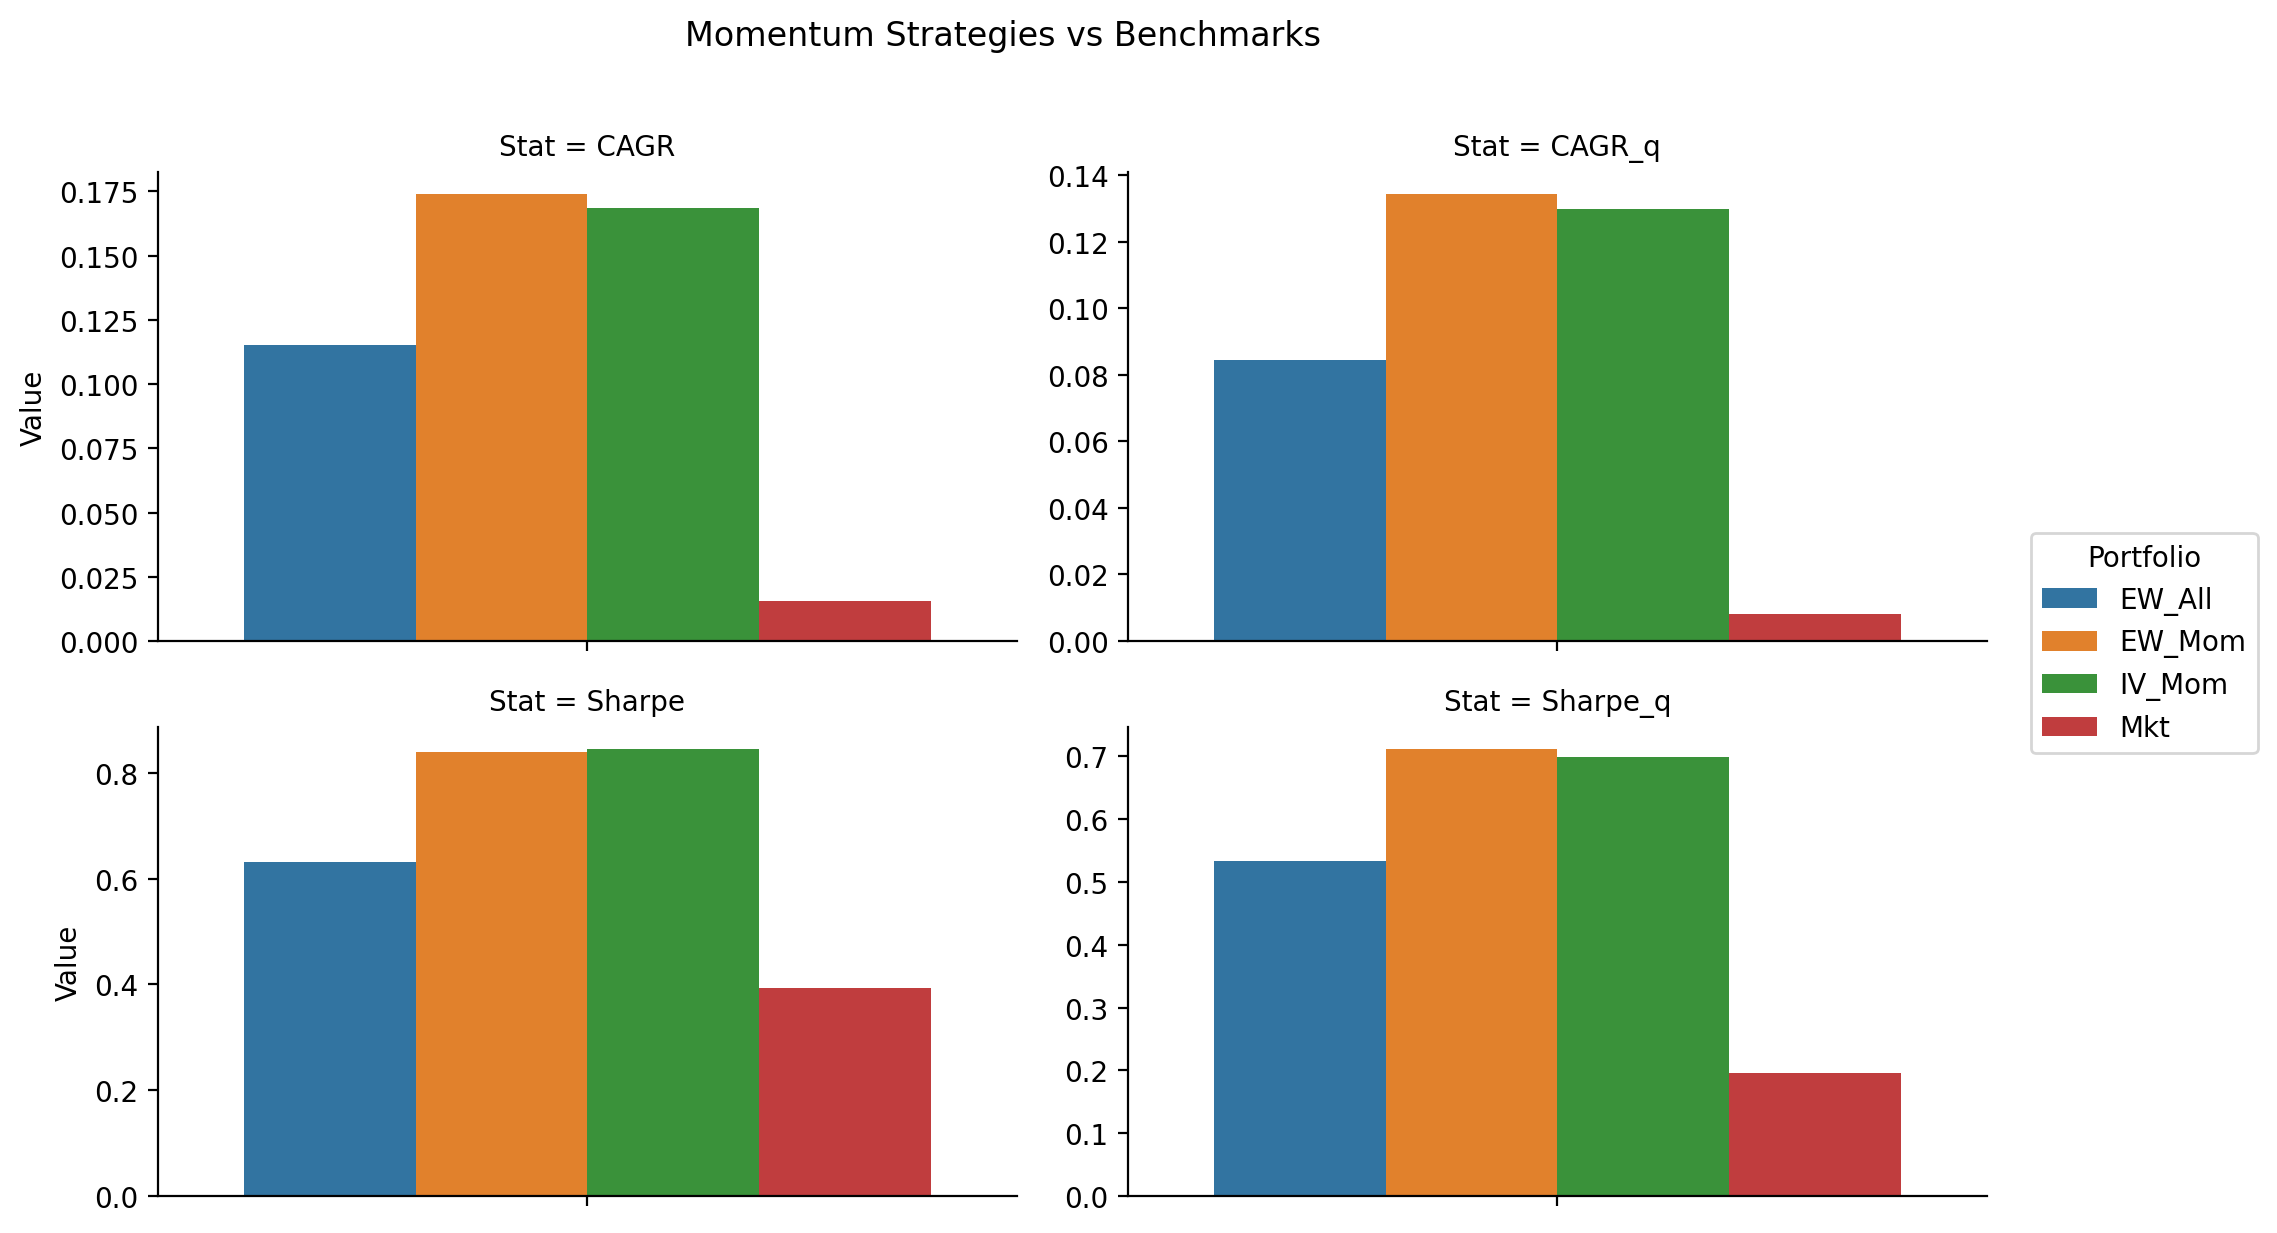

In [89]:
#| label: fig-2
#| fig-cap: |
#|   Performance comparison of momentum strategies (EW and IV) against benchmarks.
#|   Shows CAGR, worst-case CAGR (25th percentile), Sharpe ratio, and worst-case Sharpe ratio.
g = (
    df_4
    .stack()
    .sort_index()
    .to_frame('Value')
    .reset_index()
    .pipe(
        sns.catplot,
        hue='Portfolio',
        y='Value',
        kind='bar',
        col='Stat',
        col_wrap=2,
        sharey=False,
        height=3,
        aspect=1.5
    )
)

plt.suptitle('Momentum Strategies vs Benchmarks', y=1.02)

sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), frameon=True)

plt.tight_layout()
plt.show()